In [4]:
!pip -q install kagglehub

import os
import kagglehub

path = kagglehub.dataset_download("arevel/chess-games")
print("Dataset path:", path)
print("Files:", os.listdir(path))

100%|██████████| 1.45G/1.45G [00:19<00:00, 78.4MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/arevel/chess-games/versions/1
Files: ['chess_games.csv']


In [5]:
import os

csv_path_raw = os.path.join(path, "chess_games.csv")
if not os.path.exists(csv_path_raw):
    raise FileNotFoundError("chess_games.csv not found in downloaded dataset folder.")

print("Raw CSV:", csv_path_raw)

Raw CSV: /root/.cache/kagglehub/datasets/arevel/chess-games/versions/1/chess_games.csv


In [6]:
import pandas as pd
import numpy as np
import os

cleaned_path = "cleaned_chess_games.csv"

if os.path.exists(cleaned_path):
    print("Found existing:", cleaned_path)
    df = pd.read_csv(cleaned_path)
    print("Loaded cleaned shape:", df.shape)
else:
    usecols = ["Opening", "ECO", "Result", "WhiteElo", "BlackElo", "Event"]
    df = pd.read_csv(csv_path_raw, usecols=usecols)

    # dropna
    df = df.dropna(subset=["Opening", "ECO", "Result", "WhiteElo", "BlackElo"])

    # result clean
    def clean_result(r):
        if r == "1-0": return "white"
        if r == "0-1": return "black"
        if r in ["1/2-1/2", "1/2-½", "½-½"]: return "draw"
        return np.nan

    df["result_clean"] = df["Result"].apply(clean_result)
    df = df.dropna(subset=["result_clean"])

    # event normalize
    df["event"] = df["Event"].astype(str).str.lower().fillna("unknown")
    df["event"] = df["event"].replace({"?": "unknown"})

    # avg elo + rating bucket
    df["avg_elo"] = (df["WhiteElo"] + df["BlackElo"]) / 2

    def bucket(x):
        if x < 1200: return "Beginner"
        if x < 1600: return "Intermediate"
        if x < 2000: return "Advanced"
        return "Expert"

    df["rating_bucket"] = df["avg_elo"].apply(bucket)

    # opening family from ECO prefix
    df["opening_family"] = df["ECO"].astype(str).str[0].str.upper()
    df.loc[~df["opening_family"].isin(list("ABCDE")), "opening_family"] = "Unknown"

    # save
    df.to_csv(cleaned_path, index=False)
    print("Saved:", cleaned_path, "shape:", df.shape)

Saved: cleaned_chess_games.csv shape: (6254841, 11)


Downloading and cleaning data again since cannot upload on GitHub

In [1]:
import os, glob
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay
)

import matplotlib.pyplot as plt

We use the cleaned dataset produced in earlier steps (cleaned_chess_games.csv).

In [7]:
# Try common locations
candidates = [
    "cleaned_chess_games.csv",
    "/content/cleaned_chess_games.csv",
    "/content/drive/MyDrive/cleaned_chess_games.csv",
]

csv_path = None
for p in candidates:
    if os.path.exists(p):
        csv_path = p
        break

# If not found, search recursively (can be slow if many files)
if csv_path is None:
    hits = glob.glob("**/cleaned_chess_games.csv", recursive=True)
    if hits:
        csv_path = hits[0]

if csv_path is None:
    raise FileNotFoundError(
        "cleaned_chess_games.csv not found. Put it in the Colab working directory "
        "or update the path in candidates."
    )

print("Using:", csv_path)
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head()

Using: cleaned_chess_games.csv
Shape: (6254841, 11)


,Event,Result,WhiteElo,BlackElo,ECO,Opening,result_clean,event,avg_elo,rating_bucket,opening_family
0,Classical,1-0,1901,1896,D10,Slav Defense,white,classical,1898.5,Advanced,D
1,Blitz,0-1,1641,1627,C20,King's Pawn Opening: 2.b3,black,blitz,1634.0,Advanced,C
2,Blitz tournament,1-0,1647,1688,B01,Scandinavian Defense: Mieses-Kotroc Variation,white,blitz tournament,1667.5,Advanced,B
3,Correspondence,1-0,1706,1317,A00,Van't Kruijs Opening,white,correspondence,1511.5,Intermediate,A
4,Blitz tournament,0-1,1945,1900,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",black,blitz tournament,1922.5,Advanced,B


Target: y = 1 if White wins, 0 if Black wins

Draws are excluded for binary classification.

In [8]:
needed = [
    "result_clean",   # 'white'/'black'/'draw'
    "WhiteElo", "BlackElo",
    "opening_family", # A-E
    "event",          # blitz/rapid/bullet/classical/unknown
    "rating_bucket",  # Beginner/Intermediate/Advanced/Expert
]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns in df: {missing}")

# Drop draws
df_bin = df[df["result_clean"].isin(["white", "black"])].copy()

# Target
df_bin["y"] = (df_bin["result_clean"] == "white").astype(int)

# Numeric feature: Elo difference
df_bin["elo_diff"] = df_bin["WhiteElo"] - df_bin["BlackElo"]

print(df_bin["y"].value_counts(normalize=True))
df_bin.head()

y
1    0.517551
0    0.482449
Name: proportion, dtype: float64


,Event,Result,WhiteElo,BlackElo,ECO,Opening,result_clean,event,avg_elo,rating_bucket,opening_family,y,elo_diff
0,Classical,1-0,1901,1896,D10,Slav Defense,white,classical,1898.5,Advanced,D,1,5
1,Blitz,0-1,1641,1627,C20,King's Pawn Opening: 2.b3,black,blitz,1634.0,Advanced,C,0,14
2,Blitz tournament,1-0,1647,1688,B01,Scandinavian Defense: Mieses-Kotroc Variation,white,blitz tournament,1667.5,Advanced,B,1,-41
3,Correspondence,1-0,1706,1317,A00,Van't Kruijs Opening,white,correspondence,1511.5,Intermediate,A,1,389
4,Blitz tournament,0-1,1945,1900,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",black,blitz tournament,1922.5,Advanced,B,0,45


Training on ~6.2M rows can be very slow in Colab.
We keep the full dataset for EDA + hypothesis tests, but for ML we can sample while preserving class balance.

In [9]:
SAMPLE_FRAC = 0.20   # set to 1.0 if you want full (may be very slow)
RANDOM_STATE = 42

if SAMPLE_FRAC < 1.0:
    df_ml = df_bin.groupby("y", group_keys=False).apply(
        lambda x: x.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE)
    )
else:
    df_ml = df_bin

print("ML shape:", df_ml.shape)
df_ml["y"].value_counts(normalize=True)

ML shape: (1203193, 13)


/tmp/ipython-input-844736753.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ml = df_bin.groupby("y", group_keys=False).apply(


,proportion
y,
1,0.517551
0,0.482449


We compare:

Baseline: rating-only (elo_diff)

Full model: rating + opening_family + event + rating_bucket

In [10]:
X = df_ml[["elo_diff", "opening_family", "event", "rating_bucket"]].copy()
y = df_ml["y"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train.shape, X_test.shape


((962554, 4), (240639, 4))

Scale numeric: elo_diff

One-hot encode categorical: opening_family, event, rating_bucket

In [11]:
num_features = ["elo_diff"]
cat_features = ["opening_family", "event", "rating_bucket"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ],
    remainder="drop"
)

We train:

Majority baseline

Logistic Regression (rating-only)

Logistic Regression (full features)

Random Forest (full)

Gradient Boosting (full)

In [12]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Predict proba if available (for ROC-AUC)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"{name}")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  F1-score : {f1:.4f}")
    print(f"  ROC-AUC  : {auc:.4f}")
    return {"model": name, "accuracy": acc, "f1": f1, "roc_auc": auc}

In [13]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

results = []
results.append(evaluate_model("Baseline: Majority Class", dummy, X_test, y_test))

Baseline: Majority Class
  Accuracy : 0.5176
  F1-score : 0.6821
  ROC-AUC  : 0.5000


In [14]:
X_train_r = X_train[["elo_diff"]]
X_test_r  = X_test[["elo_diff"]]

lr_rating = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, n_jobs=None))
])

lr_rating.fit(X_train_r, y_train)
results.append(evaluate_model("LogReg: Rating only (elo_diff)", lr_rating, X_test_r, y_test))

LogReg: Rating only (elo_diff)
  Accuracy : 0.6551
  F1-score : 0.6759
  ROC-AUC  : 0.7204


In [15]:
lr_full = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=300))
])

lr_full.fit(X_train, y_train)
results.append(evaluate_model("LogReg: Full features", lr_full, X_test, y_test))

LogReg: Full features
  Accuracy : 0.6553
  F1-score : 0.6760
  ROC-AUC  : 0.7205


In [17]:
rf_full = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=50,        # ↓ 200 → 50
        max_depth=10,           # ← EN KRİTİK
        min_samples_leaf=50,    # overfitting + hız
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

rf_full.fit(X_train, y_train)
results.append(evaluate_model("RandomForest: Full features", rf_full, X_test, y_test))

RandomForest: Full features
  Accuracy : 0.6547
  F1-score : 0.6680
  ROC-AUC  : 0.7191


In [18]:
gb_full = Pipeline([
    ("prep", preprocess),
    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
])

gb_full.fit(X_train, y_train)
results.append(evaluate_model("GradientBoosting: Full features", gb_full, X_test, y_test))

GradientBoosting: Full features
  Accuracy : 0.6548
  F1-score : 0.6759
  ROC-AUC  : 0.7205


Results table

In [19]:
res_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
res_df

,model,accuracy,f1,roc_auc
0,Baseline: Majority Class,0.517551,0.682087,0.500000
2,LogReg: Full features,0.655251,0.675988,0.720462
1,LogReg: Rating only (elo_diff),0.655052,0.675950,0.720358
4,GradientBoosting: Full features,0.654807,0.675926,0.720524
3,RandomForest: Full features,0.654665,0.667969,0.719060


Confusion Matrix + ROC curve (best model)

Best: Baseline: Majority Class


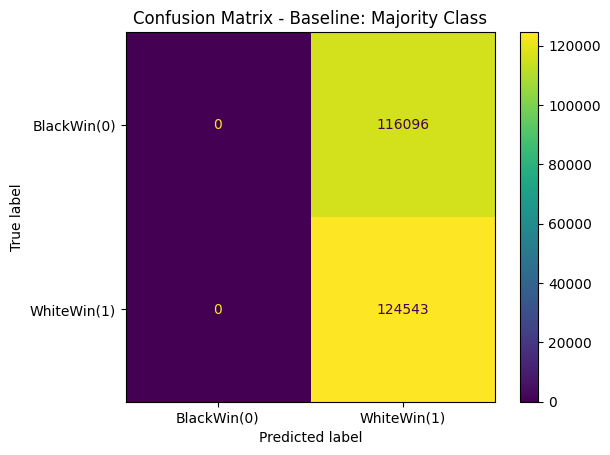

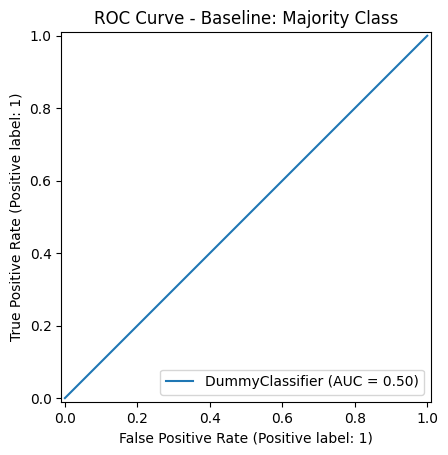

In [20]:
# Pick best model name
best_name = res_df.iloc[0]["model"]
print("Best:", best_name)

# Map name -> object
model_map = {
    "Baseline: Majority Class": dummy,
    "LogReg: Rating only (elo_diff)": lr_rating,
    "LogReg: Full features": lr_full,
    "RandomForest: Full features": rf_full,
    "GradientBoosting: Full features": gb_full,
}

best_model = model_map[best_name]

# Confusion matrix
y_pred = best_model.predict(X_test if "Rating only" not in best_name else X_test_r)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["BlackWin(0)", "WhiteWin(1)"])
disp.plot(values_format="d")
plt.title(f"Confusion Matrix - {best_name}")
plt.show()

# ROC curve if possible
if hasattr(best_model, "predict_proba"):
    RocCurveDisplay.from_estimator(
        best_model,
        X_test if "Rating only" not in best_name else X_test_r,
        y_test
    )
    plt.title(f"ROC Curve - {best_name}")
    plt.show()

Compare LogReg rating-only vs LogReg full to quantify opening-related improvement.

If full features improve F1/ROC-AUC, then openings + time control add predictive signal beyond Elo difference.

This aligns with hypothesis tests showing opening family affects outcomes under many conditions.

The majority-class baseline model predicts the same outcome for all games, corresponding to the most frequent class in the dataset. As a result, the confusion matrix shows that all instances are classified as WhiteWin, with zero correct predictions for BlackWin.

This behavior is expected and intentional. The baseline model does not utilize any game-related information such as rating difference, opening choice, or time control. Its sole purpose is to establish a lower bound for predictive performance.

The ROC curve confirms this interpretation. The diagonal shape and an AUC score of 0.50 indicate that the model performs no better than random guessing. While the baseline may achieve a deceptively high accuracy due to class imbalance, it completely fails to discriminate between the two outcome classes.

These results highlight why accuracy alone is insufficient for evaluating models on imbalanced datasets. More informative metrics such as recall, precision, F1-score, and ROC–AUC are required. Any machine learning model developed in the following sections must significantly outperform this baseline to demonstrate that features like openings, rating differences, and time controls contain meaningful predictive signal.